In [63]:
import numpy as np
import pandas as pd
import sympy as sp
import networkx as nx

import functools
from functools import reduce, partial
from toolz import *

import itertools
import more_itertools

from itertools import product, starmap

# from abc import *

# import plotly.graph_objs as go
# import plotly.express as px

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["axes.grid"] = True

plt.rcParams["font.size"] = 12

import pydot
from IPython.display import Image, SVG
from ipywidgets import interact, widgets

import operator

from typing import Sequence, Callable, Tuple, List, Union, Iterable, Any, Hashable



inf = np.inf
get_curried = curry(operator.getitem)
lmap = compose(list, map)

## Попытки полуколец в контексте ресурсных сетей

In [2]:
@curry
def plot_functions(range_, f1, *fs):
    fig, ax = plt.subplots()
    x = np.linspace(range_[0], range_[1], 200)
    for i, f in enumerate(itertools.chain([f1], fs)):
        y = lmap(f, x)
        ax.plot(x, y, label=f'function {i}')
    ax.legend()

@curry
def nth_pow(f, n):
    def inner(x):
        for _ in range(n):
            x = f(x)
        return x
    return inner

In [3]:
add1, add2 = map(curry(operator.add), [1, 2])

In [4]:
def make_resource_function(limitation, transition):
    def inner(x):
        if x > limitation:
            return transition
        else:
            return transition/limitation * x
    return inner

addf = lambda f1, f2: lambda x: f1(x) + f2(x)

In [5]:
f1 = make_resource_function(5, 7)
f2 = make_resource_function(3, 8)
f3 = make_resource_function(8, 9)


plot_here = plot_functions((0, 10))
plot_here(f1, f2)


# В композиции с собой в пределе получим константу
# plot_here(nth_pow(f1, 200))


# plot_functions((0, 10), compose(addf(f1, f2), f3), addf(compose(f1, f3), compose(f2, f3)))
# Свойства дистрибутивности не выполняются:
# plot_functions((0, 10), compose(f1, addf(f2, f3)), addf(compose(f1, f2), compose(f1, f3)))

### Правильные структуры данных

In [7]:
class PiecewiseLinearFunction:
    
    # in this class linear functions will be denoted
    LinearFunc = Tuple[float, float]
    
    Interval = Tuple[float, float]
    
    def __init__(self, x: List[float], f: List[LinearFunc]):
        assert len(x) + 1 == len(f),\
            ("Array sizes for constraining points (x) and " +
             "linear functions (f) should satisfy `len(x) + 1 == len(f), " +
             f"however len(x) == {len(x)}, len(f) == {len(f)}")
        self._x = x
        self._f = f
    
    @property
    def x(self): return self._x
    @property
    def f(self): return self._f
    
    @staticmethod
    def _is_close(x1: float, x2: float) -> bool:
        return abs(x1 - x2) < 1e-13
    
    @staticmethod
    def _linear_funcs_are_close(f1: LinearFunc, f2: LinearFunc) -> bool:
        return all(map(PiecewiseLinearFunction._is_close, f1, f2))
    
    def sanitize(self) -> 'PiecewiseLinearFunction':
        """
        Sometimes during function composition or addition
        we might get extra mesh points, like
        `f = (2*x | x <= 3), (2*x | 3 < x)`
        This function resolves it, thus f becomes simply
        `f = 2*x`
        """
        if any(starmap(PiecewiseLinearFunction._linear_funcs_are_close, 
                       sliding_window(2, self.f))):
            x, f = [], [self.f[0]]
            for i in range(len(self.x)):
                if not PiecewiseLinearFunction._linear_funcs_are_close(f[-1], self.f[i+1]):
                    x.append(self.x[i])
                    f.append(self.f[i+1])
            return PiecewiseLinearFunction(x, f)
        else:
            return self
    
    
    @staticmethod
    def _add_two(f1: LinearFunc, f2: LinearFunc):
        return (f1[0] + f2[0], f1[1] + f2[1])
    
    
    
    def merge_funcs(self,
            other: 'PiecewiseLinearFunction',
            merge_two: Callable[[LinearFunc, LinearFunc], LinearFunc])\
            -> 'PiecewiseLinearFunction':
        """
        res = merge_funcs(f1, f2, <op>) is similar to constructing 
        piecewise function, which mesh is sum of meshes of
        both f1 and f2. On each subdomain res is equal to
        `f1 <op> f2` on the according subdomains of f1 and f2
        """
        x, f = [],  []
        i = j = 0
        while i < len(self.x) and j < len(other.x):
            if PiecewiseLinearFunction._is_close(self.x[i], other.x[j]):
                x.append(self.x[i])
                f.append(merge_two(self.f[i], other.f[j]))
                i += 1
                j += 1                
            elif self.x[i] < other.x[j]:
                x.append(self.x[i])
                f.append(merge_two(self.f[i], other.f[j]))
                i += 1
            elif self.x[i] > other.x[j]:
                x.append(other.x[j])
                f.append(merge_two(self.f[i], other.f[j]))
                j += 1
        while i < len(self.x):
            x.append(self.x[i])
            f.append(merge_two(self.f[i], other.f[j]))
            i += 1
        while j < len(other.x):
            x.append(other.x[j])
            f.append(merge_two(self.f[i], other.f[j]))
            j += 1
        f.append(merge_two(self.f[i], other.f[j]))
        return PiecewiseLinearFunction(x, f).sanitize()
    
    def __add__(self, other: 'PiecewiseLinearFunction') -> 'PiecewiseLinearFunction':
        return self.merge_funcs(other, PiecewiseLinearFunction._add_two)
    
    def find_index(self, x: float) -> int:
        if len(self.x) == 0:
            res = 0
        elif x <= self.x[0]:
            res = 0
        elif self.x[-1] < x:
            res = len(self.x) # x cannot be indexed like that, though f can
        else:
            # simple binary search, actually
            l = 0
            r = len(self.x) - 1
            while r - l > 1:
                p = l + (r - l)//2
                if x <= self.x[p]:
                    r = p
                else:
                    l = p
            res = r
        return res
    
    @staticmethod
    def _inv_lin_if_possible(lin: LinearFunc) -> LinearFunc:
        if PiecewiseLinearFunction._is_close(lin[0], 0):
            raise ValueError(f"Cannot inverse constant function {lin}")
        else:
            return (1/lin[0], -lin[1]/lin[0])
    
    @staticmethod
    @curry
    def _apply_lin(lin: LinearFunc, x: float) -> float:
        if PiecewiseLinearFunction._is_close(lin[0], 0):
            return lin[1]
        else:
            return lin[0]*x + lin[1]
    
    @staticmethod
    def _interval_image(lin: LinearFunc, ival: Interval) -> Interval:
        # we assume `lin[0] != 0` 
        a, b = map(PiecewiseLinearFunction._apply_lin(lin), ival)
        return (a, b) if a < b else (b, a)
    
    def _points_and_idx_inside_interval(self, ival: Interval) -> Tuple[List[float], int]:
        ia, ib = map(self.find_index, ival)
        
        if ia == len(self.x):
            return ([], ia)
        elif ib == len(self.x):
            ia_corr = ia if not PiecewiseLinearFunction._is_close(ival[0], self.x[ia])\
                        else ia + 1
            ib_corr = ib
            return (self.x[ia_corr:ib_corr], ia_corr)
        else:
            ia_corr = ia if not PiecewiseLinearFunction._is_close(ival[0], self.x[ia])\
                        else ia + 1
            ib_corr = ib if not PiecewiseLinearFunction._is_close(ival[1], self.x[ib])\
                        else ib - 1
            if ib_corr == -1: 
                return ([], ia_corr)
            return (self.x[ia_corr:ib_corr], ia_corr)
    
    @staticmethod
    def _inverse_points(lin: LinearFunc, points: List[float]) -> List[float]:
        lin_inv = PiecewiseLinearFunction._inv_lin_if_possible(lin)
        if lin[0] > 0:
            return lmap(PiecewiseLinearFunction._apply_lin(lin_inv), points)
        else:
            # since we don't have efficient inversed map, making a plain loop here:
            res = [None]*len(points)
            for i, p in enumerate(points):
                res[- 1 - i] = PiecewiseLinearFunction._apply_lin(lin_inv, p)
            return res
#         return (reversed if lin[0] < 0 else identity)(lmap(PiecewiseLinearFunction._apply_lin(lin_inv), points))

    def partition_domain(self, f2: LinearFunc, ival: Interval)\
        -> Tuple[List[float], int]:
        """
        Provided `f2` has domain `ival` and we are to calculate `compose(f1, f2)`,
        returns a proper partition for `ival` (makes a corresponding mesh from it).
        !!! Beware, result's points don't contain `ival[0]` and `ival[1]` !!! 
        """
        #in case of constant function `f2` we're not extending the domain:
        if PiecewiseLinearFunction._is_close(f2[0], 0):
            idx = self.find_index(PiecewiseLinearFunction._apply_lin(f2, ival[1]))
            return ([], idx)
        else:
            im = PiecewiseLinearFunction._interval_image(f2, ival)
            points, idx = self._points_and_idx_inside_interval(im)
            inv_points = PiecewiseLinearFunction._inverse_points(f2, points)
            return (inv_points, idx)
    
    @staticmethod
    def _compose_lin(f1: LinearFunc, f2: LinearFunc) -> LinearFunc:
        return (f1[0]*f2[0], f1[0]*f2[1] + f1[1])
    
    @staticmethod
    def compose(f1: 'PiecewiseLinearFunction', f2: 'PiecewiseLinearFunction')\
            -> 'PiecewiseLinearFunction':
        
        def process(rhs_lin_func, ival):
            new_points, f_idx = f1.partition_domain(rhs_lin_func, ival)
            if PiecewiseLinearFunction._is_close(rhs_lin_func[0], 0) or rhs_lin_func[0] > 0:
                idx = f_idx
                new_idx = lambda old: old + 1
            else:
                idx = len(new_points) + f_idx
                new_idx = lambda old: old - 1
                
            for p in new_points:
                f.append(PiecewiseLinearFunction._compose_lin(f1.f[idx], rhs_lin_func))
                idx = new_idx(idx)
                x.append(p)
            f.append(PiecewiseLinearFunction._compose_lin(f1.f[idx], rhs_lin_func))
        
        x, f = [], []
        if len(f2.x) == 0:
            x = f1.x
            f = lmap(lambda it: PiecewiseLinearFunction._compose_lin(it, f2.f[0]),
                     f1.f)
        else:            
            # case (-inf, f2.x[0]):
            process(f2.f[0], (-inf, f2.x[0]))
            x.append(f2.x[0])
            for i in range(len(f2.x) - 1):
                process(f2.f[i+1], (f2.x[i], f2.x[i+1]))
                x.append(f2.x[i+1])
            #case (f2.x[-1], +inf):
            process(f2.f[-1], (f2.x[-1], +inf))
        
        return PiecewiseLinearFunction(x, f).sanitize()
        
    
    def __call__(self, x: float):
        k, b = self.f[self.find_index(x)]
        return k*x + b
    
    def to_str(self):
        def conv_f(f):
            if PiecewiseLinearFunction._is_close(f[0], 0):
                return '{:.6g}'.format(f[1])
            elif PiecewiseLinearFunction._is_close(f[1], 0):
                return '{:.6g}*x'.format(f[0])
            else:
                return '{:.6g}*x + {:.6g}'.format(f[0], f[1])
        def conv_x(x):
            return '{:.6g}'.format(x)
        
#         "(2*x + 3 | 0 < x <= 1), (2 | 1 < x <= 3)"
        
        if len(self.x) == 0:
            return conv_f(self.f[0])
        else:
            s0 =  f'({conv_f(self.f[0])} | x <= {conv_x(self.x[0])})'
            ls = (f'({conv_f(self.f[i])} | {conv_x(self.x[i-1])} < x <= {conv_x(self.x[i])})'
                      for i in range(1, len(self.x)))
            sn =  f'({conv_f(self.f[-1])} | {conv_x(self.x[-1])} < x)'
            
            
        return ', '.join(itertools.chain([s0], ls, [sn]))
    
    def __repr__(self):
        return 'Piecewise linear: ' +  self.to_str()

    
def resource_piecewise(limitation, transition):
    x = [0, limitation]
    f = [(0, 0), (transition/limitation, 0), (0, transition)]
    return PiecewiseLinearFunction(x, f)

def self_resource_piecewise(capacity):
    x = [capacity]
    f = [(0, 0), (1, -capacity)]
    return PiecewiseLinearFunction(x, f)

pw_compose = PiecewiseLinearFunction.compose


In [8]:
p1, p2 = resource_piecewise(1, 4), resource_piecewise(3, 5)
comp = pw_compose(p1, p2)
comp

Piecewise linear: (0 | x <= 0), (6.66667*x | 0 < x <= 0.6), (4 | 0.6 < x)

In [9]:
plot_here = plot_functions((-4, 7))

# f1_ = PiecewiseLinearFunction([1, 5, 6], [(1, 0), (3, 5), (0, 1), (-2, 4)])
# f2_ = PiecewiseLinearFunction([2, 5], [(4, 1), (-2, 8), (3, 0)])

# f1_ = PiecewiseLinearFunction([3, 4], [(1, 0), (2, 0), (3, 0)])
# f2_ = PiecewiseLinearFunction([2], [(4, 10), (1, 0)])

f1_ = PiecewiseLinearFunction([-2, 4], [(0, 0), (1, 2), (0, 0)])
f2_ = PiecewiseLinearFunction([0], [(0, 0), (-1, 0)])

comp12 = pw_compose(f1_, f2_)
print(comp12)
plot_here(comp12, compose(f1_, f2_))

Piecewise linear: (2 | x <= 0), (-1*x + 2 | 0 < x <= 2), (0 | 2 < x)


#### Собственно, алгебра и матрицы:

In [10]:
class PLF_AlgebraElement:
    
    Zero : 'PLF_AlgebraElement'
    One :  'PLF_AlgebraElement'

    def __init__(self, pwf: PiecewiseLinearFunction):
        self.pwf = pwf
    
    def __add__(self, other):
        return PLF_AlgebraElement(self.pwf + other.pwf)
    def __mul__(self, other):
        return PLF_AlgebraElement(PiecewiseLinearFunction.compose(self.pwf, other.pwf))
    def __call__(self, x):
        return self.pwf(x)

    def __repr__(self):
        return 'PLF_Alg: <' +  self.pwf.to_str() + '>'

PLF_AlgebraElement.Zero = PLF_AlgebraElement(PiecewiseLinearFunction([], [(0, 0)]))
PLF_AlgebraElement.One  = PLF_AlgebraElement(PiecewiseLinearFunction([], [(1, 0)]))

resource_alg  = compose(PLF_AlgebraElement, resource_piecewise)
resource_self = compose(PLF_AlgebraElement, self_resource_piecewise)

In [11]:
class ApplicativeMatrix:
    
    def __init__(self, matr: np.ndarray):
        self.matr = matr if isinstance(matr, np.ndarray) else np.array(matr, dtype=object) 
        self.type = None if self.matr.shape == (0, 0) else type(self.matr[0,0])
        
        def types_similar():
            for (i, j), x in np.ndenumerate(self.matr):
                yield(type(self.matr[i,j]) is self.type)

        assert all(types_similar()), \
            'Matrix elements should be of homogeneous type'
    
    
    def __matmul__(self, other: 'ApplicativeMatrix'):
        return ApplicativeMatrix(self.matr@other.matr)
    
    def __pow__(self, n):
        if n < 0:
            raise ValueError('Applicative matrix cannot be inversed')
        elif n == 0:
            if self.type is PLF_AlgebraElement:
                m = np.full(self.matr.shape, PLF_AlgebraElement.Zero, dtype=object)
                np.fill_diagonal(m, PLF_AlgebraElement.One)
                return m
            else:
                ApplicativeMatrix(np.linalg.matrix_power(self.matr, n))
        else:
            return ApplicativeMatrix(np.linalg.matrix_power(self.matr, n))
    
    def __call__(self, x: Union[List[float], np.ndarray]):
        if len(x) != self.matr.shape[1]:
            raise ValueError('Dimensions must agree')
        res = np.full((self.matr.shape[0],), None, dtype=object)
        for i in range(self.matr.shape[0]):
            res[i] = reduce(operator.add, map(lambda f, x: f(x), self.matr[i], x))
        return res
    
    def __setitem__(self, idx, val):
        self.matr[idx] = val
    
    def __repr__(self):
        return 'ApplicativeMatrix: ' +  repr(self.matr)  

In [59]:
Node = Hashable

class StateArray:
    def __init__(self, idx_descriptor: dict[int, Node], arr: np.ndarray):
        self.idx_descriptor = idx_descriptor
        self.arr = arr
#         self.reversed_node_descriptor = {v: k for k, v in node_descriptor}
    
    def __len__(self) -> int:
        return len(self.arr)
    
    def __getitem__(self, time) -> dict[Node, float]:
        t_arr = self.arr[time]
        return {node : t_arr[idx] for idx, node in self.idx_descriptor.items()}


def remove_edge_if_possible(G, edge):
    if edge in G.edges:
        G.remove_edge(*edge)

class ResourceDiGraph:
    
    def __init__(self):
        self.G = nx.DiGraph()
        self._applicative_matrix_inner: ApplicativeMatrix = None
        self._matrix_is_vaild = False
        self.edge_capacities: dict[Node, dict[Node, float]] = {}
        self._node_descriptor_inner: dict[Node, int] = {}
    
    def _refresh_matrix_and_descriptor(self):
        self._matrix_is_vaild = True
        n = len(self.G.nodes)
        self._node_descriptor_inner = dict(zip(self.G.nodes, itertools.count(0)))
        
        self._applicative_matrix_inner = ApplicativeMatrix(
            np.full((n, n), PLF_AlgebraElement.Zero, dtype=object))
        for u, v in self.G.edges:
            self._applicative_matrix_inner[
                self.node_descriptor[v],
                self.node_descriptor[u]
            ] = self.G[u][v]['resource_func']
    
    # !!! Attention !!! Applicative matrix is a *transposed* adjacency matrix
    @property
    def applicative_matrix(self) -> ApplicativeMatrix:
        if not self._matrix_is_vaild:
            self._refresh_matrix_and_descriptor()
        return self._applicative_matrix_inner
    
    @property
    def node_descriptor(self) -> dict[Node, int]:
        if not self._matrix_is_vaild:
            self._refresh_matrix_and_descriptor()
        return self._node_descriptor_inner
    
    def add_outedges_of_node(
            self,
            node: Node,
            edge_capacities: dict[Node, float]) -> 'ResourceDiGraph':

        integral_capacity = sum(edge_capacities.values())
        for v, cap in edge_capacities.items():
            remove_edge_if_possible(self.G, (node, v))
            self.G.add_edge(node, v, resource_func=resource_alg(cap, integral_capacity),
                            label=cap)
        remove_edge_if_possible(self.G, (node, node))
        self.G.add_edge(node, node, resource_func=resource_self(integral_capacity))
        
        self._matrix_is_vaild = False
        self.edge_capacities[node] = edge_capacities
        return self
    
    def run_simulation(self, initial_state: dict[Node, float], n_iters=20)\
        -> StateArray:
        if len(initial_state) != len(self.G.nodes):
            raise ValueError(
                'Incorrect initial states: expected states for ' +
                str(self.G.nodes) +
                ', while got:' +
                str(list(initial_state.keys())))
        n = len(initial_state)
        idx_descriptor = {v: k for k, v in self.node_descriptor.items()}
        res = np.zeros((n_iters, n))
        for j in range(n):
            res[0, j] = initial_state[idx_descriptor[j]]
        for i in range(1, n_iters):
            res[i] = self.applicative_matrix(res[i-1])
        return StateArray(idx_descriptor, res)
    
    def plot_with_states(self, states: StateArray) -> list[Image]:
        G = self.G.copy()
        res = [None]*len(states)
        for v in G.nodes:
            G.nodes[v]['shape'] = 'plaintext'
            if (v, v) in G.edges:
                G.remove_edge(v, v)
        for u, v in G.edges:
            G.edges[u, v]['label'] = self.edge_capacities[u][v]
        
        for i in range(len(res)):
            for v in G.nodes:            
                G.nodes[v]['label'] = f"""<<table>
                                          <tr><td>{v}</td></tr>
                                          <tr><td bgcolor='#00CC11'>{states[i][v]}</td></tr>
                                       </table>>"""
            res[i] = SVG(nx.nx_pydot.to_pydot(G).create_svg())
        return res
    
    def plot(self):
        G = self.G.copy()
        for v in G.nodes:
            if (v, v) in G.edges:
                G.remove_edge(v, v)
        for u, v in G.edges:
            G.edges[u, v]['label'] = self.edge_capacities[u][v]
        return SVG(nx.nx_pydot.to_pydot(G).create_svg())
    

In [80]:
#(transition, limitation) where (transition < limitation)
G = ResourceDiGraph()
G.add_outedges_of_node(0, {1: 3, 2: 4})
G.add_outedges_of_node(1, {0: 2, 2: 6})
sim = G.run_simulation({0: 30, 1: 50, 2: 1}, 40)
# G.plot()
pl = G.plot_with_states(sim)

In [82]:
f = lambda i: pl[i] #compose(identity, get_curried(pl))
interact(f, i=widgets.IntSlider(min=0,max=len(sim)-1,step=1,value=0)) 
None

interactive(children=(IntSlider(value=0, description='i', max=39), Output()), _dom_classes=('widget-interact',…

In [14]:
def weights_to_labels(G, prop='weight'):
    G_ = G.copy()
    for (u, v, data) in G_.edges(data=True):
        data['label'] = data.get(prop,'')
    return G_

def display_graph(G, prop_show='weight'):
    display(Image(nx.nx_pydot.to_pydot(weights_to_labels(G, prop_show)).create_png()))
    
def random_weigthed_graph(size=6, density=0.3, seed=None):
    seed = seed if seed is not None else np.random.randint(10*15)
    G = nx.fast_gnp_random_graph(6, 0.3, seed=seed, directed=True)
    for (u, v, data) in G.edges(data=True):
        G.edges[u,v]['weight'] = np.random.randint(1,10)
    return G

# G = random_weigthed_graph()
# display_graph(G)
# nx.adjacency_matrix(G).toarray()

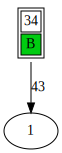

In [34]:
G = nx.DiGraph()
G.add_edge('dsd', 1, weight=2, label='43')

# G.graph['rankdir'] = 'LR'

# G.remove_edge(0, 1)
# first(G.edges(data=True))[2].get('weight')
# G.nodes['dsd']['penwidth'] = 4
# G.nodes['dsd']['label'] = """<
# <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
#   <TR><TD ROWSPAN="3" BGCOLOR="yellow">class</TD></TR>
#   <TR><TD PORT="here" BGCOLOR="lightblue">qualifier</TD></TR>
# </TABLE>>"""
G.nodes['dsd']['shape'] = 'plaintext'
G.nodes['dsd']['label'] = f"""<<table>
                          <tr><td>{'3' + '4'}</td></tr>
                          <tr><td bgcolor='#00CC11'>B</td></tr>
                       </table>>
"""
G.nodes['dsd']
SVG(nx.nx_pydot.to_pydot(G).create_svg())

In [ ]:
G_ = nx.nx_pydot.to_pydot(G)
G_.set('rankdir', 'LR')
SVG(G_.create_svg())

In [ ]:
B = np.array([[0, 2],
              [2, 0]])
# np.linalg.matrix_power(B, 2)
# np.apply_over_axes(lambda x: x**2, B, [])
B[0] = [2, 3]
B

In [ ]:
interact(f, Median_Size=widgets.IntSlider(min=1,max=21,step=2,value=1)) 